<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/Amazon_Employee_Access_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
19th, June 2023


Keep 'resource' aside while transforming features
Still get comparable results to xgboost
on full data with 'resource'

"""

## Basics
Install software and call libraries

In [2]:
%reset -f
!pip install catencfamily==0.0.78

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 67.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 66.5 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9073 sha256=86b4a6c0f4f557dc885ccdf9aa10a0cd162ce175f4b015e92df27c87137fe300
  Stored in directory: /root/.cache/pip/wheels/49/27/15/dcf90953e3e3322e6f3e447514b20cf39b53c6518cb4a7bace
Successfully built python-igraph


In [3]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.2 MB/s eta 0:00:00


In [4]:
# 1.0 Call libraries
import pandas as pd
import numpy as np



# 1.01
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import  TSNE
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report,f1_score,roc_auc_score



# 1.02
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
from networkx import community

# 1.03
import xgboost as xgb
import optuna
import imblearn
from imblearn.over_sampling import SMOTE


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils


# 1.05
import shutil
from pathlib import Path
import itertools
import warnings
warnings.filterwarnings('ignore')


Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'graph_tool', 'wurlitzer', 'bayanpy', 'leidenalg'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


In [5]:
# 1.06 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [6]:
# 1.0.7 Decide program-wide random state:

rng= np.random.RandomState(0)

## Read data
Read and pop-out

In [96]:
# Read Data:
url_tr = "https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/amazon/train.csv"
url_te = "https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/amazon/test.csv"
train = pd.read_csv(url_tr)
test = pd.read_csv(url_te)   # Does not contain action columns

In [97]:
train.head(3)
test.head(3)


,action,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880


,id,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175


In [98]:
train.shape     # (32769, 10)
test.shape      # (58921, 10)


(32769, 10)

(58921, 10)

In [99]:
train.columns

Index(['action', 'resource', 'mgrid', 'rolerollupOne', 'rolerolluptwo',
       'roledeptname', 'roletitle', 'rolefamilydesc', 'rolefamily',
       'rolecode'],
      dtype='object')

In [100]:
y = train.pop("action")
_= test.pop("id")


In [101]:
# Is data balanced? No.
y.value_counts()
y.value_counts(normalize = True)  # 95%:6%


1    30872
0     1897
Name: action, dtype: int64

1    0.94211
0    0.05789
Name: action, dtype: float64

In [102]:
# Check nulls. None.
train.isnull().sum().sum()
test.isnull().sum().sum()

0

0

## Partition data
`X_train/X_test`

In [105]:
## Developing models
X_train, X_test, y_train,y_test = train_test_split(train,
                                                   y,
                                                   test_size=0.25,
                                                   stratify=y,
                                                   random_state=rng)

In [106]:
X_train.shape  #  (24576, 9)
X_test.shape   #  (8193, 9)
y_train.shape  # (24576,)
y_test.shape   # (8193,)



(24576, 9)

(8193, 9)

(24576,)

(8193,)

In [107]:
X_train.head(2)
X_test.head(2)

,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
21576,33054,5652,117961,118300,28618,118321,117906,290919,118322
24128,100929,17006,117902,118041,118623,117946,118806,292795,117948


,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
17956,5410,26320,117961,118327,118391,117905,240983,290919,117908
7871,43839,8430,117961,118225,118403,117905,117906,290919,117908


In [108]:
# No of unique values in columns:

for i in train.columns:
  print(f"No of unique values in '{i}' are:           \t\t{train[i].nunique()}")

No of unique values in 'resource' are:           		7518
No of unique values in 'mgrid' are:           		4243
No of unique values in 'rolerollupOne' are:           		128
No of unique values in 'rolerolluptwo' are:           		177
No of unique values in 'roledeptname' are:           		449
No of unique values in 'roletitle' are:           		343
No of unique values in 'rolefamilydesc' are:           		2358
No of unique values in 'rolefamily' are:           		67
No of unique values in 'rolecode' are:           		343


## Learning to transform
Fit `CatEncodersFamily` class on `X_train`

In [109]:
# Which are our cat columns?
# We will consider for transformation
# all columns but 'resource'

cat_cols = ['mgrid', 'rolerollupOne', 'rolerolluptwo', 'roledeptname',
           'roletitle', 'rolefamilydesc', 'rolefamily', 'rolecode']

len(cat_cols)  # 8. 'resource' is not included

# Keep interacting columns an empty list
interactingCatCols = []


8

In [110]:
# 5.0 Instantiate CatEncodersFamily class. We will also save
#     graphs created:
#     Folder  /content/allmodels/models created to deposit cat encoder models and graph related files

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,0,None,1,1],
                       saveGraph = True,
                       k = 40
                       )

# 5.1 Fit it using only train_dataset.
#     While fitting, 'target' is not needed.
#     Takes time...

ct.fit(X_train, cat_cols, interactingCatCols)

Folder  /content/allmodels/models created to deposit cat encoder models and graph related files
Record set no is 1  
Set of records is:  [('mgrid', 'rolerollupOne', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolerolluptwo', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'roledeptname', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'roletitle', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolefamilydesc', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolefamily', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolecode', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'mgrid', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'rolerolluptwo', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'roledeptname', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'roletitle', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'rolefamilydesc', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'rolefamily', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'rolecode', [1, 1, 1, 0, None, 1, 1]), ('rolerolluptwo', 'mgrid', [1, 1, 1, 0, None, 1, 1]), ('rolerolluptwo', 'rolerollu

CatEncodersFamily(k=40, modelsPath=PosixPath('/content/allmodels/models'),
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'),
                  saveGraph=True)

## Data transformation:
Transform `X_train` and `X_test` using fitted 1`CatEncodersFamily` object

In [111]:
# 6.0 Transform both test_binned and train_binned data:

test_trans = ct.transform(X_test[cat_cols])

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  224
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 14.354136 MB
Mem usage after dtype transformation is: 7.472016 MB


'Transformed test data shape: (8193, 218)'

In [112]:
# 6.0.1 Transform train_binned now:

train_trans= ct.transform(X_train[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  224
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 43.057152 MB
Mem usage after dtype transformation is: 22.413312 MB


'Transformed train data shape: (24576, 218)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [113]:
# 6.1 Observe data now:
#     It also has original binned cols (6):

train_trans.head()
test_trans.head()

,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,5652,117961,118300,28618,118321,117906,290919,118322,0.421409,0.024383,...,0.012948,0.045421,0.033435,0.060423,1.963706e-01,0.007149,0.002537,0.030211,2.343220e-18,0.003116
1,17006,117902,118041,118623,117946,118806,292795,117948,0.032590,0.000079,...,0.003136,0.001144,-0.081768,0.033233,7.840677e-03,0.005419,0.001224,0.018127,-2.366941e-17,0.003116
2,13854,117961,118052,118821,118278,117906,290919,118279,0.421409,0.024383,...,0.007567,0.006445,0.057008,0.054381,1.894036e-01,0.006184,0.000349,0.030211,7.927173e-18,0.003116
3,5899,117961,118327,120318,118641,240982,118643,118644,0.421409,0.024383,...,0.006503,0.005276,0.062627,0.027190,3.417411e-02,0.004193,0.005501,0.030211,5.838348e-18,0.003116
4,6876,117978,117979,117920,121067,229187,121069,121070,0.427425,0.024383,...,0.001968,0.000028,0.061923,0.000000,-7.085013e-18,0.000581,0.000000,0.000000,8.587679e-18,0.000467


,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,26320,117961,118327,118391,117905,240983,290919,117908,0.421409,0.024383,...,0.013494,0.053028,0.063206,0.072508,0.199386,0.008765,0.018172,0.030211,-3.235615e-18,0.003116
1,8430,117961,118225,118403,117905,117906,290919,117908,0.421409,0.024383,...,0.013494,0.053028,0.063206,0.072508,0.199386,0.008765,0.018172,0.030211,-3.235615e-18,0.003116
2,13304,117961,118327,123757,118636,128696,118638,118639,0.421409,0.024383,...,0.010514,0.029312,0.043828,0.060423,0.073272,0.008886,0.016012,0.012085,3.533810e-17,0.003116
3,46254,117961,118327,126310,124886,306399,118643,124888,0.421409,0.024383,...,0.005026,0.016394,-0.056424,0.030211,0.038593,0.004529,0.006524,0.030211,1.493149e-18,0.003116
4,34611,117961,118327,118320,118321,117906,290919,118322,0.421409,0.024383,...,0.012948,0.045421,0.033435,0.060423,0.196371,0.007149,0.002537,0.030211,2.343220e-18,0.003116


In [114]:
# 6.1.1
train_trans.shape   #   (24576, 218)
test_trans.shape    #  (8193, 218)

(24576, 218)

(8193, 218)

In [115]:
# 6.1.2 Save ct to current folder:
utils.savePythonObject(ct, "transformer.pkl")

Object saved to: /content/transformer.pkl


## Make an archive of files in gdrive
Save `X_train/X_test`, `CatEncodersFamily` object and transformed data to your gdrive for subsequent use


In [119]:
# 6.2 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [120]:
# Delete folder 'amazonemp' if it exists:

!rm -r -f /gdrive/MyDrive/Colab_data_files/amazonemp

### Archive of graph files to gdrive

In [121]:
# 6.2.1 Delete if a folder already exists on gdrive:
outputfolder = Path("/gdrive/MyDrive/Colab_data_files/amazonemp/")
if outputfolder.exists() and outputfolder.is_dir():
    shutil.rmtree(outputfolder)  # Delete if it exists

In [122]:
# 6.3 Archive folder where graph files are stored to gdrive
output_filename = outputfolder / "models"
dir_to_be_archived = "/content/allmodels/models/"
shutil.make_archive(output_filename, 'zip', dir_to_be_archived )


# 6.3.2 Unpack the zipped file at gdrive now:
shutil.unpack_archive(str(output_filename) +".zip", output_filename, 'zip')

'/gdrive/MyDrive/Colab_data_files/amazonemp/models.zip'

In [123]:
# 6.4 Let us have a look at our list of (graph) stored files:
graphfolder = Path(r'/gdrive/MyDrive/Colab_data_files/amazonemp/models')
p = graphfolder.glob('**/*')
files = [x for x in p if x.is_file()]
files[:3]

[PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/models/rolefamily_projected_rolefamilydesc.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/models/rolecode_bigraph_roledeptname.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/models/rolerolluptwo_projected_roledeptname.gml')]

### Archive of datafiles

#### Save to local destination

In [124]:
# 6.5  Let us also copy our original and binned
#      files to a local folder
#       We will later copy them to gfrive:


destination = Path("/content/datafiles/data/")
destination.mkdir(parents=True, exist_ok=True)


# Full file paths:
# Our train/test data
trfile = destination / "X_train.pkl"
tefile = destination / "X_test.pkl"
ytr = destination / "y_train.pkl"
yte = destination / 'y_test.pkl'

# Our transformed data
trtrans = destination / 'train_trans.pkl'
tetrans = destination / 'test_trans.pkl'


# Now save
X_train.to_pickle(trfile)
X_test.to_pickle(tefile)
y_train.to_pickle(ytr)
y_test.to_pickle(yte)
train_trans.to_pickle(trtrans)
test_trans.to_pickle(tetrans)

#### Transfer from local to gdrive

In [125]:
# 6.5.1 Delete if a folder already exists on gdrive:
outputfolder = Path("/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/")
if outputfolder.exists() and outputfolder.is_dir():
    shutil.rmtree(outputfolder)  # Delete if it exists

In [126]:
# 6.5.2 Archive folder where pickle files are stored to gdrive
output_filename = outputfolder / "data"
dir_to_be_archived = "/content/datafiles/data/"
shutil.make_archive(output_filename, 'zip', dir_to_be_archived )



# 6.6 Unpack the zipped file now:
shutil.unpack_archive(str(output_filename)+".zip", output_filename, 'zip')

'/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data.zip'

### Archive of transformer object

In [127]:
# 6.7 Also copy 'transformer.pkl' to gdrive
datafolder = "/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/"
shutil.copy('/content/transformer.pkl', datafolder + 'transformer.pkl')


'/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/transformer.pkl'

### Our data files on gdrive

In [128]:
# 6.8 Let us have a look at our list of pickled data files:
datafolder = Path(r"/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data")
p = datafolder.glob('**/*')
files = [x for x in p if x.is_file()]
files

[PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/y_test.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/X_test.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/y_train.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/X_train.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/test_trans.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/train_trans.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/transformer.pkl')]

## Read back archived datafiles
Read back saved objects and data files from gdrive archive

In [129]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [130]:
datafolder = "/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/"

X_train = pd.read_pickle(datafolder + "X_train.pkl")
X_test = pd.read_pickle(datafolder+ "X_test.pkl")
y_train = pd.read_pickle(datafolder + "y_train.pkl")
y_test = pd.read_pickle(datafolder + "y_test.pkl")

train_trans = pd.read_pickle(datafolder +"train_trans.pkl")
test_trans = pd.read_pickle(datafolder + "test_trans.pkl")
ct = pd.read_pickle(datafolder + "transformer.pkl")

In [131]:
# Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,5652,117961,118300,28618,118321,117906,290919,118322,0.421409,0.024383,...,0.012948,0.045421,0.033435,0.060423,0.196371,0.007149,0.002537,0.030211,2.343220e-18,0.003116
1,17006,117902,118041,118623,117946,118806,292795,117948,0.032590,0.000079,...,0.003136,0.001144,-0.081768,0.033233,0.007841,0.005419,0.001224,0.018127,-2.366941e-17,0.003116


,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,26320,117961,118327,118391,117905,240983,290919,117908,0.421409,0.024383,...,0.013494,0.053028,0.063206,0.072508,0.199386,0.008765,0.018172,0.030211,-3.235615e-18,0.003116
1,8430,117961,118225,118403,117905,117906,290919,117908,0.421409,0.024383,...,0.013494,0.053028,0.063206,0.072508,0.199386,0.008765,0.018172,0.030211,-3.235615e-18,0.003116


,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
21576,33054,5652,117961,118300,28618,118321,117906,290919,118322
24128,100929,17006,117902,118041,118623,117946,118806,292795,117948


,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
17956,5410,26320,117961,118327,118391,117905,240983,290919,117908
7871,43839,8430,117961,118225,118403,117905,117906,290919,117908


In [132]:
cat_cols = ['mgrid', 'rolerollupOne', 'rolerolluptwo', 'roledeptname',
           'roletitle', 'rolefamilydesc', 'rolefamily', 'rolecode']
len(cat_cols)

8

## xgboost modeling of original data and of transformed data:

In [ ]:
# 9.0 Original train/test data:
#     Includes 'resource' column

model_orig = xgb.XGBClassifier( n_estimators= 500,
                           verbosity = 3,
                           eta = 0.04,
                           max_depth = 15,
                           subsample = 0.9,           # 0.8
                           random_state = rng,
                           reg_lambda = 1.5,
                            )


tr_X =   X_train
test_X = X_test
ytr = y_train
yte = y_test


model_orig.fit(tr_X, ytr.values,
               early_stopping_rounds = 100,
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
               eval_metric = ['auc']
              )


[07:09:32] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[07:09:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.65008	validation_1-auc:0.65042
[07:09:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.65492	validation_1-auc:0.65835
[07:09:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.71667	validation_1-auc:0.71092
[07:09:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.76000	validation_1-auc:0.74198
[07:09:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=15
[4]	validation_0-auc:0.76288	validation_1-auc:0.74465
[07:09:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 318 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.04, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

'Best auc from orig train/test data: 0.8649344895575223'

'Best iteration from orig train/test data: 206'

In [ ]:
# Modeling with transformed data
# (Excludes 'resource' column)

model_trans = xgb.XGBClassifier( n_estimators= 1000,
                                verbosity = 3,
                                eta = 0.04,
                                max_depth = 13,
                                subsample = 0.9,
                                random_state = rng,
                                reg_lambda = 1.5,


                           )

## NOTE THIS IS WITHOT resource column
tr_X =  train_trans.iloc[:,len(cat_cols):]
test_X = test_trans.iloc[:,len(cat_cols):]
ytrain = y_train
ytest = y_test


model_trans.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']    # binary classification problem
          )

[07:10:19] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[07:10:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.75129	validation_1-auc:0.72690
[07:10:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.79625	validation_1-auc:0.76426
[07:10:21] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.82422	validation_1-auc:0.77489
[07:10:22] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.83170	validation_1-auc:0.78126
[07:10:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=13
[4]	validation_0-auc:0.83539	validation_1-auc:0.78374
[07:10:28] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 366 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.04, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

### Learning curve plots

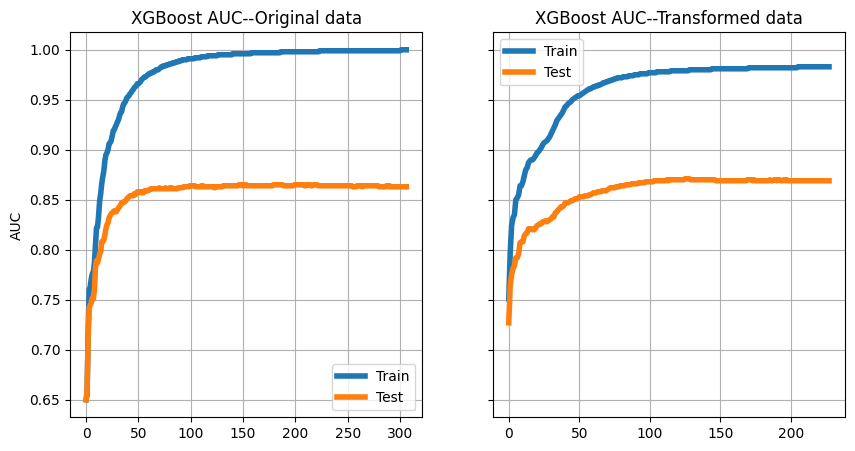

In [ ]:
# 9.3 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = True);

results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=4, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=4, label='Test');
ax[0].legend();
ax[0].grid()
ax[0].set_ylabel('AUC');
ax[0].set_title("XGBoost AUC--Original data")

# 9.4 Modeling with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],3), linewidth=4, label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth = 4, label='Test');
ax[1].legend();
ax[1].grid()
ax[1].set_title('XGBoost AUC--Transformed data');
plt.show();

In [ ]:
# 9.5
f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"

'Best auc from transformed train/test data: 0.8707182069779048'

'Best iteration from transformed train/test data: 127'

### Classification reports

In [ ]:
pred_orig = model_orig.predict(X_test)
pred_trans = model_trans.predict(test_X)

print("Note that the f1-score from transformed data is better than that from original data\n")
print(f"Classification report from original data: \n {classification_report(ytest,pred_orig)}")
print("\n==================\n")
print(f"Classification report from transformed data: \n {classification_report(ytest,pred_trans)}")

"""
Note that the f1-score from transformed data is better than that from original data

Classification report from original data:
               precision    recall  f1-score   support

           0       0.71      0.27      0.39       474
           1       0.96      0.99      0.97      7719

    accuracy                           0.95      8193
   macro avg       0.83      0.63      0.68      8193
weighted avg       0.94      0.95      0.94      8193


==================

Classification report from transformed data:
               precision    recall  f1-score   support

           0       0.64      0.37      0.47       474
           1       0.96      0.99      0.97      7719

    accuracy                           0.95      8193
   macro avg       0.80      0.68      0.72      8193
weighted avg       0.94      0.95      0.95      8193

"""

Note that the f1-score from transformed data is better than that from original data

Classification report from original data: 
               precision    recall  f1-score   support

           0       0.71      0.27      0.39       474
           1       0.96      0.99      0.97      7719

    accuracy                           0.95      8193
   macro avg       0.83      0.63      0.68      8193
weighted avg       0.94      0.95      0.94      8193



Classification report from transformed data: 
               precision    recall  f1-score   support

           0       0.64      0.37      0.47       474
           1       0.96      0.99      0.97      7719

    accuracy                           0.95      8193
   macro avg       0.80      0.68      0.72      8193
weighted avg       0.94      0.95      0.95      8193



## PCAs with transformed data:

In [ ]:
# Check if any nulls in data
#  else we would impute using SimpleImputer:

train_trans.isnull().sum().sum()
test_trans.isnull().sum().sum()   # > 16800
pca_train = train_trans.iloc[:,len(cat_cols):]   # Drop the initial cat columns
pca_test  = test_trans.iloc[:,len(cat_cols):]   # Drop the initial cat columns

0

16884

In [ ]:
si = SimpleImputer(strategy = 'median')
pca_train[:] = si.fit_transform(pca_train)
pca_test[:] = si.transform(pca_test)

In [ ]:
# 7.1 2D PCA with transformed train data.
#     Drop the initial cat_cols first:

pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
pca_train = pca.fit_transform(ss.fit_transform(pca_train))
pca_test = pca.transform(ss.transform(pca_test))

In [ ]:
# 7.3 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(pca_train.shape[1])]
pca_train = pd.DataFrame(pca_train, columns = colnames)
pca_test = pd.DataFrame(pca_test, columns = colnames)

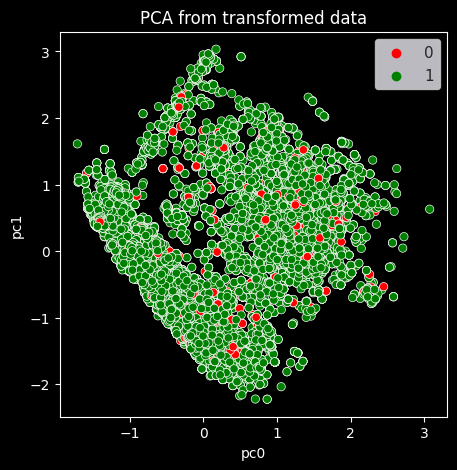

In [ ]:
# 8.1 2D PCA plot from original train data:
fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
plt.style.use("dark_background");
sns.set_theme() ; # Set default theme
sns.scatterplot(data = pca_train,
                x= 'pc0',
                y = 'pc1',
                hue = y_train.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed data') ;



## How good is PCA?
We perform predictive analytics with the 2-components

In [ ]:
model_pca = xgb.XGBClassifier( n_estimators= 1000,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 15,
                              subsample = 0.8,
                              random_state = rng
                           )


tr_X = pca_train
test_X = pca_test
ytrain = y_train
ytest = y_test


model_pca.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']    # binary classification problem
          )

# We need test_X for future
# So copy it:
test_X_pca =test_X.copy()


[07:17:31] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[07:17:31] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.58196	validation_1-auc:0.57428
[07:17:31] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.65622	validation_1-auc:0.64093
[07:17:31] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.65909	validation_1-auc:0.63573
[07:17:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.68904	validation_1-auc:0.66789
[07:17:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=15
[4]	validation_0-auc:0.69424	validation_1-auc:0.67246
[07:17:33] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned node

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

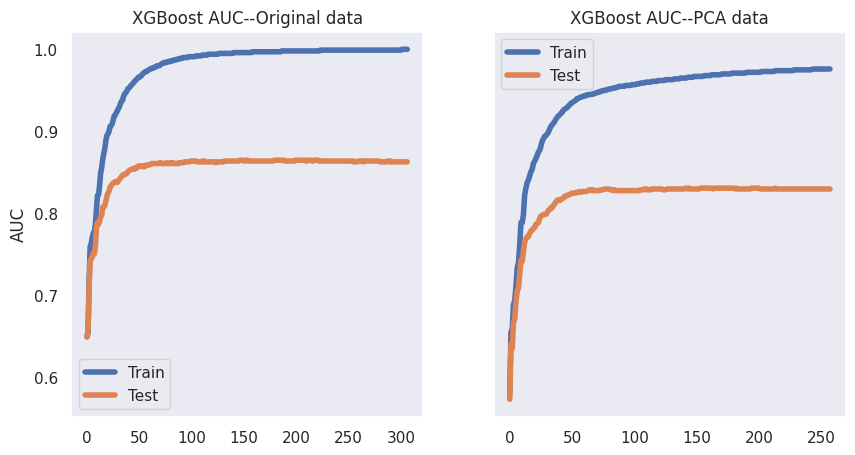

In [ ]:
# 9.3 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = True);

results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=4, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=4, label='Test');
ax[0].legend();
ax[0].grid()
ax[0].set_ylabel('AUC');
ax[0].set_title("XGBoost AUC--Original data")

# 9.4 Modeling with transformed data:

results = model_pca.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],3), linewidth=4, label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth = 4, label='Test');
ax[1].legend();
ax[1].grid()
ax[1].set_title('XGBoost AUC--PCA data');
plt.show();

In [ ]:
pred_orig = model_orig.predict(X_test)
pred_pca = model_pca.predict(test_X)

print("Note that the difference in the two classification reports exist but not to great extent\n")
print(f"Classification report from original data: \n {classification_report(ytest,pred_orig)}")
print("\n==================\n")
print(f"Classification report from PCA data: \n {classification_report(ytest,pred_pca)}")

"""
Note that the difference in the two classification reports exist but not to great extent

Classification report from original data:
               precision    recall  f1-score   support

           0       0.71      0.27      0.39       474
           1       0.96      0.99      0.97      7719

    accuracy                           0.95      8193
   macro avg       0.83      0.63      0.68      8193
weighted avg       0.94      0.95      0.94      8193


==================

Classification report from PCA data:
               precision    recall  f1-score   support

           0       0.66      0.28      0.39       474
           1       0.96      0.99      0.97      7719

    accuracy                           0.95      8193
   macro avg       0.81      0.63      0.68      8193
weighted avg       0.94      0.95      0.94      8193


"""

Note that the difference in the two classification reports exist but not to great extent

Classification report from original data: 
               precision    recall  f1-score   support

           0       0.71      0.27      0.39       474
           1       0.96      0.99      0.97      7719

    accuracy                           0.95      8193
   macro avg       0.83      0.63      0.68      8193
weighted avg       0.94      0.95      0.94      8193



Classification report from PCA data: 
               precision    recall  f1-score   support

           0       0.66      0.28      0.39       474
           1       0.96      0.99      0.97      7719

    accuracy                           0.95      8193
   macro avg       0.81      0.63      0.68      8193
weighted avg       0.94      0.95      0.94      8193



## tsne

In [ ]:
# Instantiate class:
tsne = TSNE(perplexity = 30)  # 30 gives best AUC
                              # Tried 20 and 50

# Fit and transform
ss = StandardScaler()
da = tsne.fit_transform(ss.fit_transform(train_trans.iloc[:, len(cat_cols) : ]))

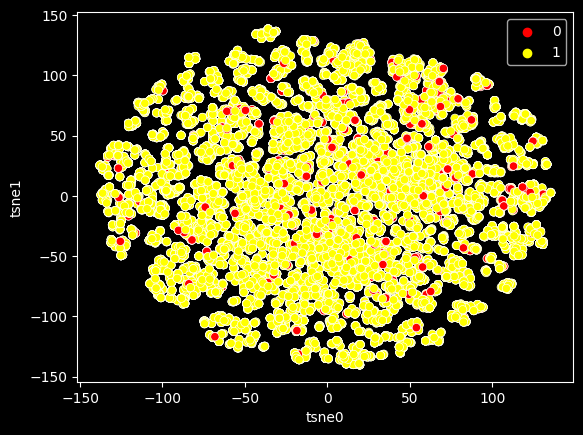

In [ ]:
# Plot tsne output:

colnames = ["tsne" + str(i) for i in range(da.shape[1])]
da = pd.DataFrame(da, columns = colnames)
plt.figure(100);
sns.scatterplot(x= da['tsne0'], y = da['tsne1'], hue = y_train.values, palette = ["red", "yellow"]);

## How good is tsne data in making predictions?

In [ ]:
# tsne class in sklearn does not have a transform method
# We cannot transform our test_trans data using tsne-object
# learnt during training of train_trans:
# Let us partition tsne-transformed data itself:

Xtrain, Xtest, ytr, yte = train_test_split(da,
                                           y_train,
                                           test_size = 0.20,
                                           stratify= y_train,
                                           random_state = rng)

model_tsne = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           random_state = rng
                           )


tr_X =  Xtrain
test_X = Xtest



model_tsne.fit(tr_X, ytr,
          early_stopping_rounds = 100,
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']
          )

[07:29:09] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[07:29:09] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.62536	validation_1-auc:0.58885
[07:29:09] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.64559	validation_1-auc:0.59720
[07:29:09] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.65036	validation_1-auc:0.59945
[07:29:09] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.65893	validation_1-auc:0.60243
[07:29:09] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.66768	validation_1-auc:0.61297
[07:29:09] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_d

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

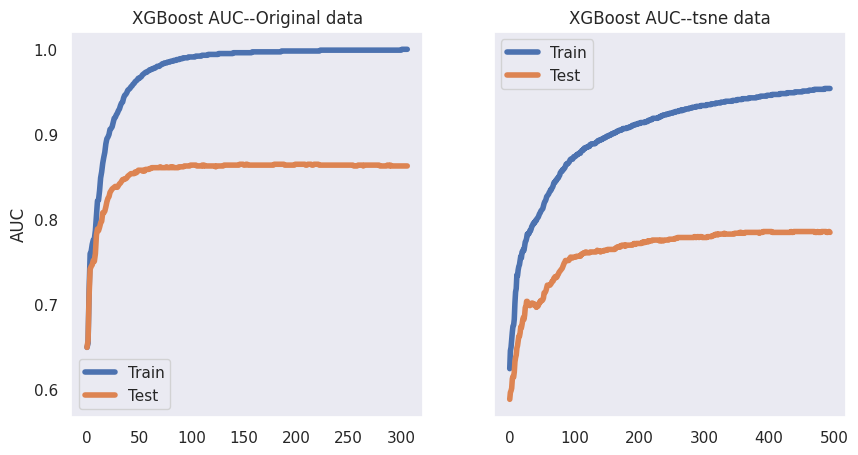

In [ ]:
# 9.3 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = True);

results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=4, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=4, label='Test');
ax[0].legend();
ax[0].grid()
ax[0].set_ylabel('AUC');
ax[0].set_title("XGBoost AUC--Original data")

# 9.4 Modeling with transformed data:

results = model_tsne.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],3), linewidth=4, label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth = 4, label='Test');
ax[1].legend();
ax[1].grid()
ax[1].set_title('XGBoost AUC--tsne data');
plt.show();

In [ ]:
pred_pca = model_pca.predict(test_X_pca)
pred_tsne = model_tsne.predict(test_X)

print("Note that the difference in the two classification reports exist. PCA modeling is superior\n")
print(f"Classification report from PCA data: \n {classification_report(ytest,pred_pca)}")
print("\n==================\n")
print(f"Classification report from tsne data: \n {classification_report(yte,pred_tsne)}")

"""
Note that the difference in the two classification reports exist. PCA modeling is superior

Classification report from PCA data:
               precision    recall  f1-score   support

           0       0.66      0.28      0.39       474
           1       0.96      0.99      0.97      7719

    accuracy                           0.95      8193
   macro avg       0.81      0.63      0.68      8193
weighted avg       0.94      0.95      0.94      8193


==================

Classification report from tsne data:
               precision    recall  f1-score   support

           0       0.77      0.09      0.17       285
           1       0.95      1.00      0.97      4631

    accuracy                           0.95      4916
   macro avg       0.86      0.55      0.57      4916
weighted avg       0.94      0.95      0.93      4916

"""

Note that the difference in the two classification reports exist. PCA modeling is superior

Classification report from PCA data: 
               precision    recall  f1-score   support

           0       0.66      0.28      0.39       474
           1       0.96      0.99      0.97      7719

    accuracy                           0.95      8193
   macro avg       0.81      0.63      0.68      8193
weighted avg       0.94      0.95      0.94      8193



Classification report from tsne data: 
               precision    recall  f1-score   support

           0       0.77      0.09      0.17       285
           1       0.95      1.00      0.97      4631

    accuracy                           0.95      4916
   macro avg       0.86      0.55      0.57      4916
weighted avg       0.94      0.95      0.93      4916



## Hyperpaarameter tuning--original data

In [ ]:
# REf: https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
# Maximise f1_score.

# Original data
tr_X =  X_train
test_X = X_test
ytrain = y_train
ytest = y_test



# Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
             }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_pred = optuna_model.predict(test_X)

    # Evaluate predictions
    f1 = f1_score(ytest, y_pred, pos_label = 0)
    # Maximise f1-score
    return f1



# Create optuna study
study = optuna.create_study(direction='maximize')
# Begin optimization
study.optimize(objective, n_trials=300)
# Can run this function again to optimize further
#study.optimize(objective, n_trials=200)



[I 2023-06-18 07:30:36,094] A new study created in memory with name: no-name-c3c6229b-f1c8-4dc0-a895-901d8949878b
[I 2023-06-18 07:30:43,315] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 12, 'learning_rate': 0.010179748874719013, 'n_estimators': 330, 'min_child_weight': 8, 'gamma': 1.930462527716111e-07, 'subsample': 0.2985885758841852, 'colsample_bytree': 0.021283861556582698, 'reg_alpha': 3.6730355504206594e-05, 'reg_lambda': 0.0010889994737840923}. Best is trial 0 with value: 0.0.
[I 2023-06-18 07:30:43,805] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 3, 'learning_rate': 0.12301584348655936, 'n_estimators': 104, 'min_child_weight': 10, 'gamma': 0.05941236016952219, 'subsample': 0.21268015188814943, 'colsample_bytree': 0.12283785545890052, 'reg_alpha': 2.153156523805785e-05, 'reg_lambda': 4.962588138105004e-05}. Best is trial 0 with value: 0.0.
[I 2023-06-18 07:30:47,865] Trial 2 finished with value: 0.2578512396694215 and parameters: {'max_depth'

In [ ]:

# After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# Best trial
trial = study.best_trial
trial.value   # Best trial result (f1-score)
# Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

"""
Number of finished trials: 300

0.48721071863581

    max_depth: 10
    learning_rate: 0.560617208930175
    n_estimators: 385
    min_child_weight: 4
    gamma: 3.9677811983420706e-07
    subsample: 0.9926970202031392
    colsample_bytree: 0.39634887845300765
    reg_alpha: 0.13448504458692984
    reg_lambda: 0.22566571338789548



"""


Number of finished trials: 300


0.48721071863581

    max_depth: 10
    learning_rate: 0.560617208930175
    n_estimators: 385
    min_child_weight: 4
    gamma: 3.9677811983420706e-07
    subsample: 0.9926970202031392
    colsample_bytree: 0.39634887845300765
    reg_alpha: 0.13448504458692984
    reg_lambda: 0.22566571338789548


'\nNumber of finished trials: 300\n\n0.4613297150610583\n\n    max_depth: 11\n    learning_rate: 0.09241072584073019\n    n_estimators: 500\n    min_child_weight: 1\n    gamma: 3.4803802239460285e-08\n    subsample: 0.5645806845398095\n    colsample_bytree: 0.6633102304516548\n    reg_alpha: 0.00021777398899647734\n    reg_lambda: 4.694559900759883e-06\n\n\n'

In [ ]:

# Use these parameters in our estimator:
best_params = trial.params

model = xgb.XGBClassifier(**best_params)
model.fit(tr_X, y_train)

# Make predictions and assessments:
y_pred_op = model.predict(test_X)
print(classification_report(y_test, y_pred_op))

"""
       precision    recall  f1-score   support

           0       0.58      0.42      0.49       474
           1       0.97      0.98      0.97      7719

    accuracy                           0.95      8193
   macro avg       0.77      0.70      0.73      8193
weighted avg       0.94      0.95      0.94      8193
"""

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.39634887845300765, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.9677811983420706e-07, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.560617208930175, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=385, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

              precision    recall  f1-score   support

           0       0.58      0.42      0.49       474
           1       0.97      0.98      0.97      7719

    accuracy                           0.95      8193
   macro avg       0.77      0.70      0.73      8193
weighted avg       0.94      0.95      0.94      8193



'\n       precision    recall  f1-score   support\n\n           0       0.65      0.36      0.46       474\n           1       0.96      0.99      0.97      7719\n\n    accuracy                           0.95      8193\n   macro avg       0.80      0.67      0.72      8193\nweighted avg       0.94      0.95      0.94      8193\n\n'

## Hyperparameter tuning--transformed data and SMOTE

### Generate synthetic data with SMOTE:

In [ ]:
# Train/test data
# Filter out initial cat_cols
# Keep only their numeric
# transformations

tr_X =  train_trans.iloc[:, len(cat_cols):]
test_X = test_trans.iloc[:, len(cat_cols):]
ytrain = y_train
ytest = y_test

# Apply SMOTE
sm = SMOTE(random_state=rng)
X_res, y_res = sm.fit_resample(tr_X, ytrain)
X_res.shape  # (46306, 210)

(46306, 210)

### Train/test data after SMOTE

In [ ]:
tr_X = X_res
test_X = test_trans.iloc[:,len(cat_cols):]
ytrain = y_res
ytest = y_test


### Apply optuna for hyperparameter tuning


In [ ]:
# Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
    }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_pred = optuna_model.predict(test_X)

    # Evaluate predictions
    f1 = f1_score(ytest, y_pred, pos_label = 0)
    # Maximise f1-score
    return f1



# Create optuna study
study = optuna.create_study(direction='maximize')
# Begin optimization
study.optimize(objective, n_trials=50)


[I 2023-06-18 08:12:24,730] A new study created in memory with name: no-name-929d7cbd-71fb-4b46-af57-cf1e4b1acca8
[I 2023-06-18 08:13:19,015] Trial 0 finished with value: 0.4789991063449509 and parameters: {'max_depth': 8, 'learning_rate': 0.8953412216620011, 'n_estimators': 500, 'min_child_weight': 8, 'gamma': 0.005631036450698727, 'subsample': 0.25742623184067565, 'colsample_bytree': 0.09765267862419774, 'reg_alpha': 0.0011826324923429263, 'reg_lambda': 3.77392183963221e-05}. Best is trial 0 with value: 0.4789991063449509.
[I 2023-06-18 08:13:31,837] Trial 1 finished with value: 0.2795061728395062 and parameters: {'max_depth': 3, 'learning_rate': 0.0519559434235984, 'n_estimators': 148, 'min_child_weight': 1, 'gamma': 0.3612066279063347, 'subsample': 0.11891902337026708, 'colsample_bytree': 0.23603498273564177, 'reg_alpha': 0.11004247816041167, 'reg_lambda': 1.4419063486830444e-05}. Best is trial 0 with value: 0.4789991063449509.
[I 2023-06-18 08:13:47,789] Trial 2 finished with valu

### Get optuna results

In [ ]:
# After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# Best trial
trial = study.best_trial
trial.value   # Best trial,  0.5168986083499006
# Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


# Use these parameters in our estimator:
best_params = trial.params

"""
Number of finished trials: 50

0.5452755905511811

    max_depth: 14
    learning_rate: 0.16713617697501307
    n_estimators: 132
    min_child_weight: 1
    gamma: 7.021017655710888e-05
    subsample: 0.6877378049820365
    colsample_bytree: 0.04897406890173597
    reg_alpha: 1.0163299827507004e-06
    reg_lambda: 1.1389177152979647e-05



"""




Number of finished trials: 50


0.5452755905511811

    max_depth: 14
    learning_rate: 0.16713617697501307
    n_estimators: 132
    min_child_weight: 1
    gamma: 7.021017655710888e-05
    subsample: 0.6877378049820365
    colsample_bytree: 0.04897406890173597
    reg_alpha: 1.0163299827507004e-06
    reg_lambda: 1.1389177152979647e-05


'\nNumber of finished trials: 50\n\n0.5412935323383083\n\n    max_depth: 11\n    learning_rate: 0.2543914789394467\n    n_estimators: 495\n    min_child_weight: 1\n    gamma: 0.6043311358074919\n    subsample: 0.5936718869626503\n    colsample_bytree: 0.15059918455161286\n    reg_alpha: 2.631981909419132e-07\n    reg_lambda: 1.3012764856130338e-06\n\n\n'

### xgboost modeling with tuned hyperparameters

In [ ]:
model = xgb.XGBClassifier(**best_params)
model.fit(tr_X, ytrain)

# Make predictions and assessments:
y_pred = model.predict(test_X)
print(classification_report(ytest, y_pred))

"""
      recision    recall  f1-score   support

           0       0.51      0.58      0.55       474
           1       0.97      0.97      0.97      7719

    accuracy                           0.94      8193
   macro avg       0.74      0.78      0.76      8193
weighted avg       0.95      0.94      0.95      8193

"""

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.04897406890173597, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=7.021017655710888e-05, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.16713617697501307, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=132, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

              precision    recall  f1-score   support

           0       0.51      0.58      0.55       474
           1       0.97      0.97      0.97      7719

    accuracy                           0.94      8193
   macro avg       0.74      0.78      0.76      8193
weighted avg       0.95      0.94      0.95      8193



'\n       precision    recall  f1-score   support\n\n           0       0.51      0.57      0.54       474\n           1       0.97      0.97      0.97      7719\n\n    accuracy                           0.94      8193\n   macro avg       0.74      0.77      0.76      8193\nweighted avg       0.95      0.94      0.95      8193\n\n'

## Analysing Graphs

### Read graph files from gdrive

In [7]:
# 16.0 Mount gdrive:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [9]:
# 16.1 Path where .gml files are placed:

pathToFolder = Path("/gdrive/MyDrive/Colab_data_files/amazonemp/models")
filelist = sorted(list(pathToFolder.iterdir()))
filelist[5:10]   # mgrid_bigraph_*

[PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/models/mgrid_bigraph_rolerolluptwo.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/models/mgrid_bigraph_roletitle.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/models/mgrid_projected_rolecode.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/models/mgrid_projected_roledeptname.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/models/mgrid_projected_rolefamily.gml')]

### Read data files from gdrive:

In [10]:
# 16.2 Read original and transformed data:

# Oriinal data:
X_train = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/X_train.pkl")
X_test = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/X_test.pkl")
y_train = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/y_train.pkl")
y_test = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/y_test.pkl")

# Transformed data:
train_trans = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/train_trans.pkl")
test_trans = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/test_trans.pkl")

In [11]:
# 16.3 check data files:
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)
y_train.head(2)
y_test.head(2)

,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,5652,117961,118300,28618,118321,117906,290919,118322,0.421409,0.024383,...,0.012948,0.045421,0.033435,0.060423,0.196371,0.007149,0.002537,0.030211,2.343220e-18,0.003116
1,17006,117902,118041,118623,117946,118806,292795,117948,0.032590,0.000079,...,0.003136,0.001144,-0.081768,0.033233,0.007841,0.005419,0.001224,0.018127,-2.366941e-17,0.003116


,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,26320,117961,118327,118391,117905,240983,290919,117908,0.421409,0.024383,...,0.013494,0.053028,0.063206,0.072508,0.199386,0.008765,0.018172,0.030211,-3.235615e-18,0.003116
1,8430,117961,118225,118403,117905,117906,290919,117908,0.421409,0.024383,...,0.013494,0.053028,0.063206,0.072508,0.199386,0.008765,0.018172,0.030211,-3.235615e-18,0.003116


,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
21576,33054,5652,117961,118300,28618,118321,117906,290919,118322
24128,100929,17006,117902,118041,118623,117946,118806,292795,117948


,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
17956,5410,26320,117961,118327,118391,117905,240983,290919,117908
7871,43839,8430,117961,118225,118403,117905,117906,290919,117908


21576    1
24128    1
Name: action, dtype: int64

17956    1
7871     1
Name: action, dtype: int64

### Display graphs--Bigraphs and Projected

In [34]:
# 17.0 Get sample list of projected and bigraphs:

projected = [str(i).split("/")[-1] for i in filelist if 'rolerollupOne_projected' in str(i)]

bigraphs = [str(i).split("/")[-1] for i in filelist if 'rolerollupOne_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:8]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:8]    # projected graph files

['rolerollupOne_bigraph_mgrid.gml',
 'rolerollupOne_bigraph_rolecode.gml',
 'rolerollupOne_bigraph_roletitle.gml',
 'rolerollupOne_bigraph_rolefamily.gml',
 'rolerollupOne_bigraph_roledeptname.gml',
 'rolerollupOne_bigraph_rolerolluptwo.gml',
 'rolerollupOne_bigraph_rolefamilydesc.gml']



====



['rolerollupOne_projected_mgrid.gml',
 'rolerollupOne_projected_rolecode.gml',
 'rolerollupOne_projected_roletitle.gml',
 'rolerollupOne_projected_rolefamily.gml',
 'rolerollupOne_projected_roledeptname.gml',
 'rolerollupOne_projected_rolerolluptwo.gml',
 'rolerollupOne_projected_rolefamilydesc.gml']

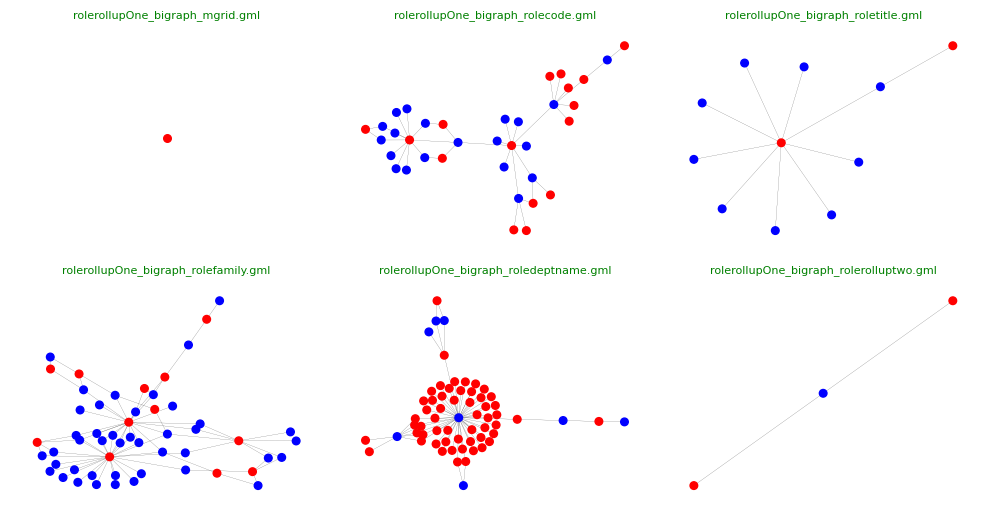

In [67]:
# 17.1 Plot of sample bigraphs:
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:6]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _=plotBipartiteGraph(bi,pathToFolder, ax = ax, title = bi, connected = True, takeGraphSample = True);
    plt.tight_layout();

In [ ]:
# 17.1 Plot of sample bigraphs:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:6]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _=utils.plotBipartiteGraph(bi,pathToFolder, ax = ax, title = bi, connected = True);
    plt.tight_layout();

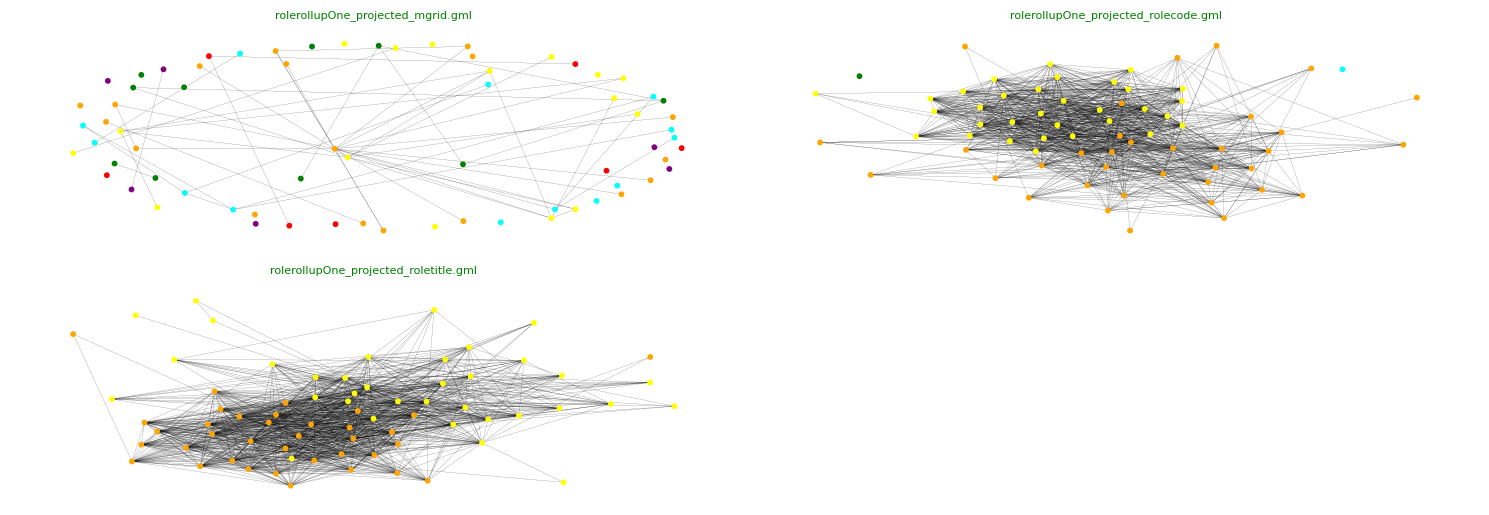

In [70]:
# 17.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:3]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=communityVisualization(prj,pathToFolder,ax = ax, k = 1.5, withLabels = False, node_size = 10, title = prj, takeGraphSample = True);
    plt.tight_layout();

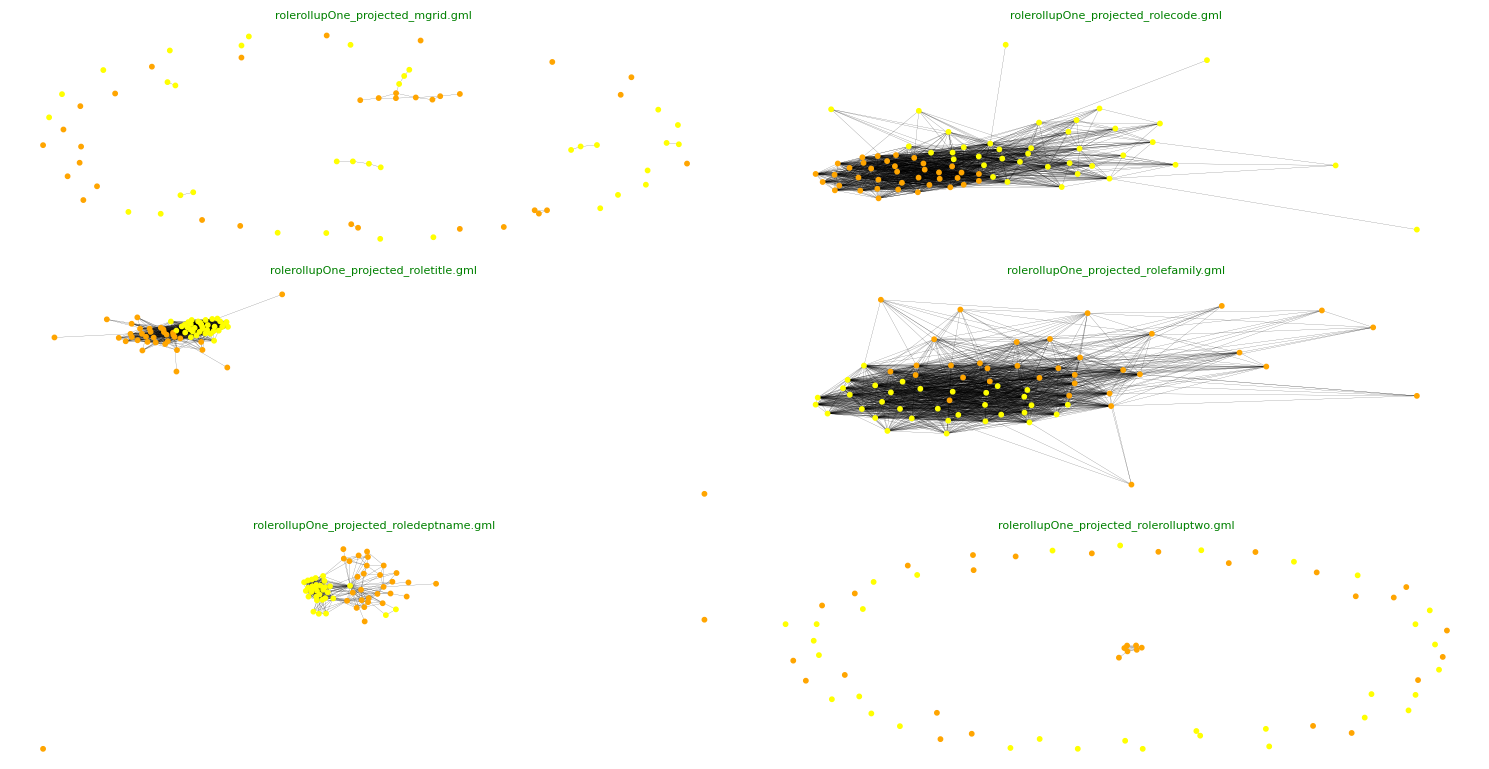

In [79]:
# 17.2.1 Community visualization using
#        kernighan_lin_bisection algo:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:6]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=communityVisualization(prj,pathToFolder,algo = nx.community.kernighan_lin_bisection,node_size = 10, ax = ax, withLabels = False, title = prj, takeGraphSample = True);
    plt.tight_layout();

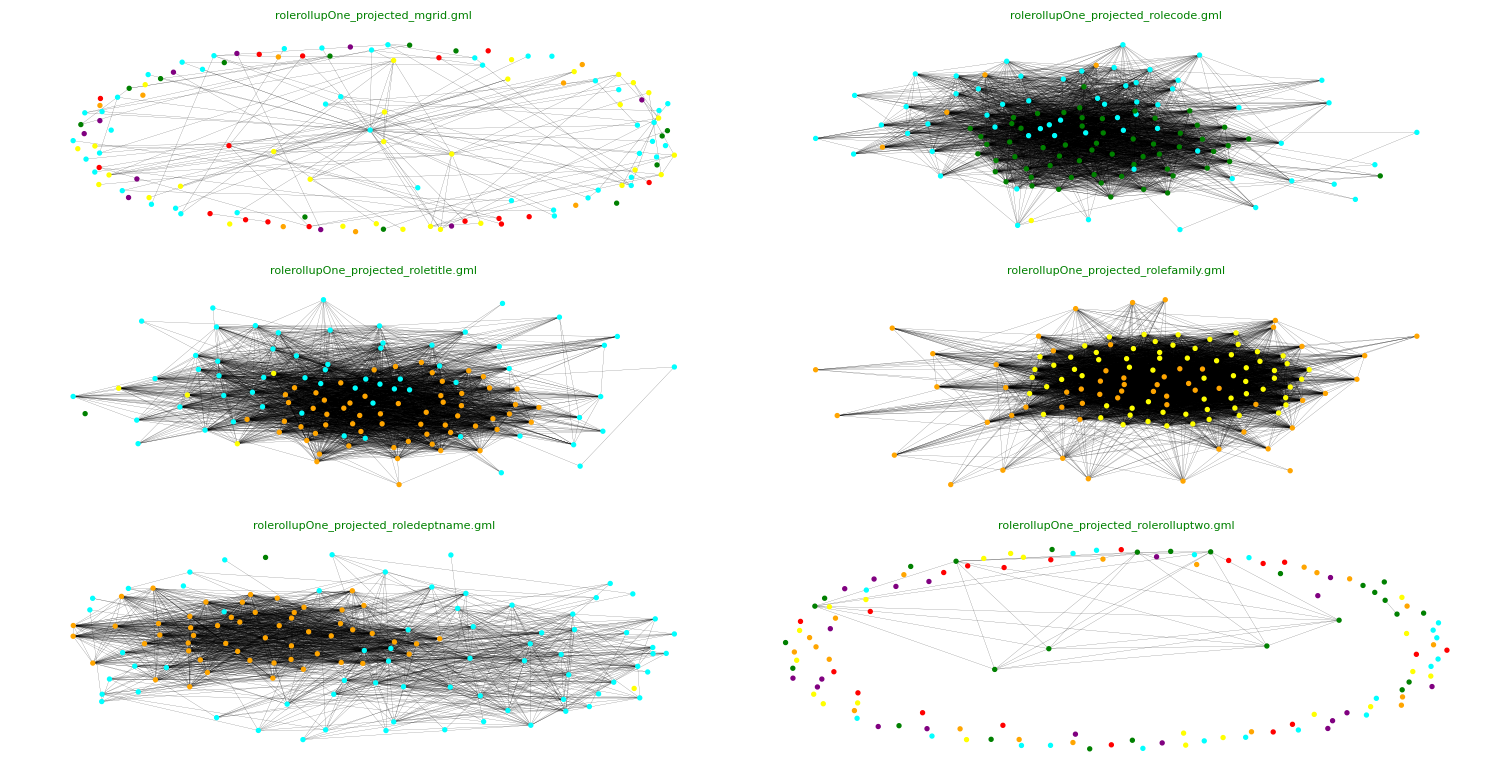

In [75]:
# 17.2.2 Community visualization using
#        louvain_communities algo:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:6]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=communityVisualization(prj,pathToFolder,algo = nx.community.louvain_communities,node_size = 8,k =1.5, ax = ax, withLabels = False, title = prj);
    plt.tight_layout();

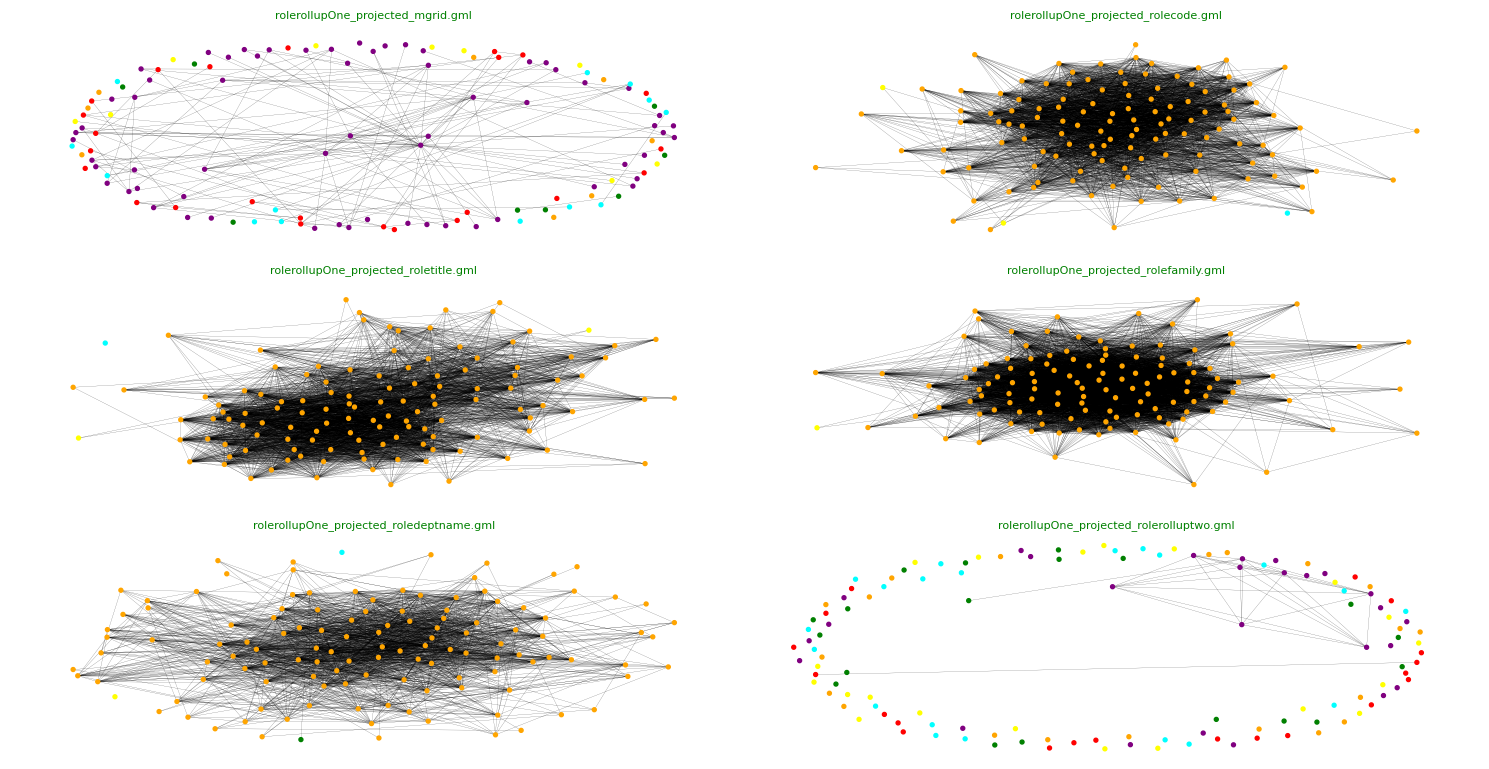

In [77]:
# 17.2.3 Community visualization using
#        girvan_newman algo:
import itertools
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:6]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=communityVisualization(prj,pathToFolder,algo = nx.community.girvan_newman,node_size = 8, k = 1.5, ax = ax, withLabels = False, title = prj);
    plt.tight_layout();

## Transform original data to communities:

In [142]:
# 18.0 Transform each column bin as per the community
#       to which it belongs:

# 18.1 Our transformed discrete cols are:
columnNames = cat_cols

# 18.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 18.3 Graph files are within:
pathToGraphFolder= "/gdrive/MyDrive/Colab_data_files/amazonemp/models"

# 18.4 Perform transformation of both train_binned and test_binend:
# 18.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []
map_tr = []
map_te = []

# 18.4.2 PErform transformation to community structure
for algo in algolist:
  print("\n..Transforming train data....")
  print("==========================\n")
  map1,df_tr = utils.transformBinnedDF2Communities(columnNames,pathToGraphFolder,X_train[cat_cols], algo = algo)
  print("\n==========================")
  print("..Transforming test data....")
  print("==========================\n")
  map2,df_te = utils.transformBinnedDF2Communities(columnNames,pathToGraphFolder,X_test[cat_cols], algo = algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)
  map_tr.append(map1)
  map_te.append(map2)

Reading file:  mgrid_projected_rolerollupOne.gml
Reading file:  mgrid_projected_rolerolluptwo.gml
Reading file:  mgrid_projected_roledeptname.gml
Reading file:  mgrid_projected_roletitle.gml
Reading file:  mgrid_projected_rolefamilydesc.gml
Reading file:  mgrid_projected_rolefamily.gml
Reading file:  mgrid_projected_rolecode.gml
Reading file:  rolerollupOne_projected_mgrid.gml
Reading file:  rolerollupOne_projected_rolerolluptwo.gml
Reading file:  rolerollupOne_projected_roledeptname.gml
Reading file:  rolerollupOne_projected_roletitle.gml
Reading file:  rolerollupOne_projected_rolefamilydesc.gml
Reading file:  rolerollupOne_projected_rolefamily.gml
Reading file:  rolerollupOne_projected_rolecode.gml
Reading file:  rolerolluptwo_projected_mgrid.gml
Reading file:  rolerolluptwo_projected_rolerollupOne.gml
Reading file:  rolerolluptwo_projected_roledeptname.gml
Reading file:  rolerolluptwo_projected_roletitle.gml
Reading file:  rolerolluptwo_projected_rolefamilydesc.gml
Reading file:  ro

In [143]:
# 18.5 Observe few rows of transformed data:
fg_tr[0].shape   # (24576, 52)
print("--")
fg_te[0].shape
print("--")
fg_tr[0].head(2)
fg_te[0].head(2)

(24576, 52)

--


(8193, 52)

--


,mgrid_projected_rolerollupOne.gml,mgrid_projected_rolerolluptwo.gml,mgrid_projected_roledeptname.gml,mgrid_projected_roletitle.gml,mgrid_projected_rolefamilydesc.gml,mgrid_projected_rolefamily.gml,mgrid_projected_rolecode.gml,rolerollupOne_projected_mgrid.gml,rolerollupOne_projected_rolerolluptwo.gml,rolerollupOne_projected_roledeptname.gml,...,rolefamily_projected_rolerollupOne.gml,rolefamily_projected_rolerolluptwo.gml,rolefamily_projected_roledeptname.gml,rolefamily_projected_rolefamilydesc.gml,rolecode_projected_mgrid.gml,rolecode_projected_rolerollupOne.gml,rolecode_projected_rolerolluptwo.gml,rolecode_projected_roledeptname.gml,rolecode_projected_rolefamilydesc.gml,rolecode_projected_rolefamily.gml
21576,0,2,1,1,1,0,1,0,0,0,...,1,2,2,0,0,1,1,0,5,6
24128,1,4,3,3,3,4,3,1,92,0,...,1,0,1,1,1,1,1,1,6,12


,mgrid_projected_rolerollupOne.gml,mgrid_projected_rolerolluptwo.gml,mgrid_projected_roledeptname.gml,mgrid_projected_roletitle.gml,mgrid_projected_rolefamilydesc.gml,mgrid_projected_rolefamily.gml,mgrid_projected_rolecode.gml,rolerollupOne_projected_mgrid.gml,rolerollupOne_projected_rolerolluptwo.gml,rolerollupOne_projected_roledeptname.gml,...,rolefamily_projected_rolerollupOne.gml,rolefamily_projected_rolerolluptwo.gml,rolefamily_projected_roledeptname.gml,rolefamily_projected_rolefamilydesc.gml,rolecode_projected_mgrid.gml,rolecode_projected_rolerollupOne.gml,rolecode_projected_rolerolluptwo.gml,rolecode_projected_roledeptname.gml,rolecode_projected_rolefamilydesc.gml,rolecode_projected_rolefamily.gml
17956,0.0,8.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0,2.0,6.0
7871,0.0,3.0,6.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0,2.0,6.0


In [144]:
# 19.0 Remove constant columns:
fg_tr[0] = utils.remConstColumns(fg_tr[0])

# 19.0.1 Keem same columns as above:
fg_te[0] = fg_te[0][fg_tr[0].columns]

Datashape before processing: (24576, 52)
Datashape after processing: (24576, 52)


## Save community transformed data to gdrive
We can analyse it at peace

In [145]:
# Save the list to gdrive:
myfolder = "/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/"
utils.savePythonObject(fg_tr, "fg_tr.pkl", myfolder)
utils.savePythonObject(fg_te, "fg_te.pkl", myfolder)

Object saved to: /gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/fg_tr.pkl
Object saved to: /gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/fg_te.pkl


In [ ]:
#!cp /content/fg_tr.pkl  /gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/fg_tr.pkl
#!cp /content/fg_te.pkl  /gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/fg_te.pkl


## Read back community transformed data from gdrive

In [146]:
tr_comm = utils.restorePythonObject( "fg_tr.pkl", myfolder )
te_comm = utils.restorePythonObject( "fg_te.pkl", myfolder )

In [147]:
# Check restoration:
tr_comm[0].head(2)
te_comm[0].head(2)

,mgrid_projected_rolerollupOne.gml,mgrid_projected_rolerolluptwo.gml,mgrid_projected_roledeptname.gml,mgrid_projected_roletitle.gml,mgrid_projected_rolefamilydesc.gml,mgrid_projected_rolefamily.gml,mgrid_projected_rolecode.gml,rolerollupOne_projected_mgrid.gml,rolerollupOne_projected_rolerolluptwo.gml,rolerollupOne_projected_roledeptname.gml,...,rolefamily_projected_rolerollupOne.gml,rolefamily_projected_rolerolluptwo.gml,rolefamily_projected_roledeptname.gml,rolefamily_projected_rolefamilydesc.gml,rolecode_projected_mgrid.gml,rolecode_projected_rolerollupOne.gml,rolecode_projected_rolerolluptwo.gml,rolecode_projected_roledeptname.gml,rolecode_projected_rolefamilydesc.gml,rolecode_projected_rolefamily.gml
21576,0,2,1,1,1,0,1,0,0,0,...,1,2,2,0,0,1,1,0,5,6
24128,1,4,3,3,3,4,3,1,92,0,...,1,0,1,1,1,1,1,1,6,12


,mgrid_projected_rolerollupOne.gml,mgrid_projected_rolerolluptwo.gml,mgrid_projected_roledeptname.gml,mgrid_projected_roletitle.gml,mgrid_projected_rolefamilydesc.gml,mgrid_projected_rolefamily.gml,mgrid_projected_rolecode.gml,rolerollupOne_projected_mgrid.gml,rolerollupOne_projected_rolerolluptwo.gml,rolerollupOne_projected_roledeptname.gml,...,rolefamily_projected_rolerollupOne.gml,rolefamily_projected_rolerolluptwo.gml,rolefamily_projected_roledeptname.gml,rolefamily_projected_rolefamilydesc.gml,rolecode_projected_mgrid.gml,rolecode_projected_rolerollupOne.gml,rolecode_projected_rolerolluptwo.gml,rolecode_projected_roledeptname.gml,rolecode_projected_rolefamilydesc.gml,rolecode_projected_rolefamily.gml
17956,0.0,8.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0,2.0,6.0
7871,0.0,3.0,6.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0,2.0,6.0


## Check data columns
Our predictors should not have target columns

In [149]:
# Check again if target is in predictors!

'target' in list(tr_comm[0].columns)
'target' in list(te_comm[0].columns)
'action' in list(tr_comm[0].columns)
'action' in list(te_comm[0].columns)

False

False

False

False

## xgboost modeling from community indicators:

In [150]:
# 19.2 Modeling with transformed train/test data with community indicators:

# As we repeat the process many times:
# Del the earlier result, if exists:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 500,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = None,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = y_train
yte = y_test


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 100,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[00:27:44] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[00:27:44] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.72604	validation_1-auc:0.70057
[00:27:44] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=14
[1]	validation_0-auc:0.73818	validation_1-auc:0.71917
[00:27:44] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.75653	validation_1-auc:0.73955
[00:27:45] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.76209	validation_1-auc:0.74488
[00:27:45] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=14
[4]	validation_0-auc:0.76519	validation_1-auc:0.74735
[00:27:45] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

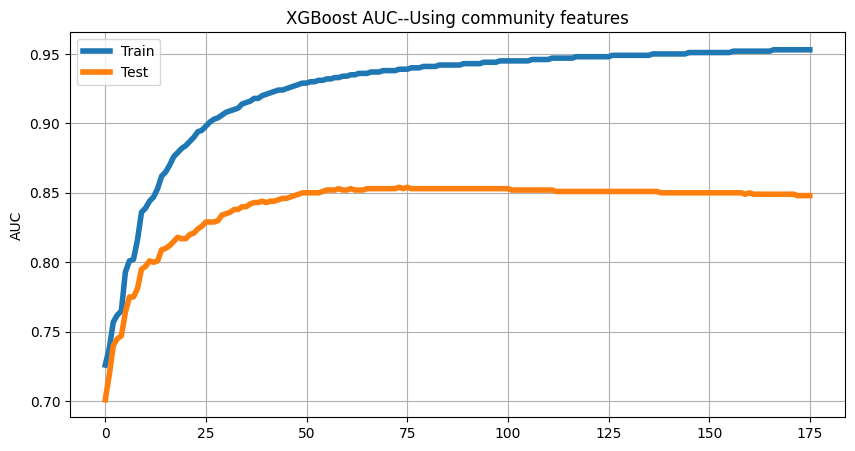

In [151]:
# 19.3 Modeling with Community data:

# Ref: https://stackoverflow.com/a/60366515
plt.figure(figsize = (10,5));
results = model_trans_commu.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=4, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=4, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Using community features");


### PCA using community indicators:

In [152]:
# 20.0 Impute train data:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy = "most_frequent")
fg_tr[0][:] = si.fit_transform(fg_tr[0])
fg_tr[0].head(3)

,mgrid_projected_rolerollupOne.gml,mgrid_projected_rolerolluptwo.gml,mgrid_projected_roledeptname.gml,mgrid_projected_roletitle.gml,mgrid_projected_rolefamilydesc.gml,mgrid_projected_rolefamily.gml,mgrid_projected_rolecode.gml,rolerollupOne_projected_mgrid.gml,rolerollupOne_projected_rolerolluptwo.gml,rolerollupOne_projected_roledeptname.gml,...,rolefamily_projected_rolerollupOne.gml,rolefamily_projected_rolerolluptwo.gml,rolefamily_projected_roledeptname.gml,rolefamily_projected_rolefamilydesc.gml,rolecode_projected_mgrid.gml,rolecode_projected_rolerollupOne.gml,rolecode_projected_rolerolluptwo.gml,rolecode_projected_roledeptname.gml,rolecode_projected_rolefamilydesc.gml,rolecode_projected_rolefamily.gml
21576,0,2,1,1,1,0,1,0,0,0,...,1,2,2,0,0,1,1,0,5,6
24128,1,4,3,3,3,4,3,1,92,0,...,1,0,1,1,1,1,1,1,6,12
194,0,10,0,1,1,0,1,0,0,0,...,1,2,2,0,0,2,2,0,5,6


In [153]:
# 20.1 PCA next:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
commu_pca = pca.fit_transform(ss.fit_transform(fg_tr[0]))

# 20.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(commu_pca.shape[1])]
commu_pca = pd.DataFrame(commu_pca, columns = colnames)

In [154]:
# https://stackoverflow.com/a/64554001/3282777
# Generate jitter around values by center+random_frac, center-random frac

def jitter(values,center):
    return values + np.random.normal(center,0.2,values.shape)

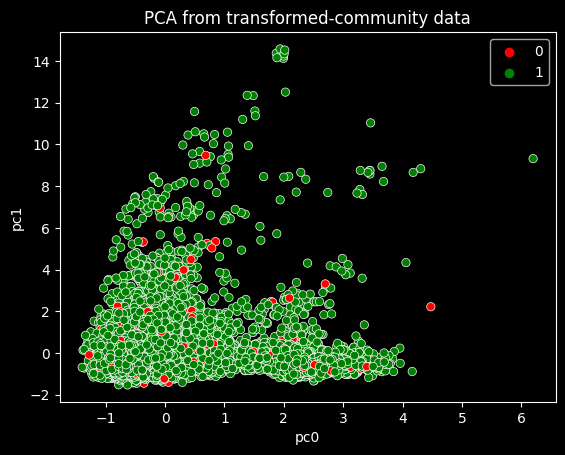

In [155]:
# 20.3 PCA plot of transformed data:
#      We add some jitter to display
#      overlapping points

plt.style.use("dark_background")
sns.scatterplot(data = commu_pca,
                x=  jitter(commu_pca.pc0, 0),
                y = jitter(commu_pca.pc1, 0),
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed-community data') ;

In [ ]:

##*****************************
## Embedding Projector
## Incidentally f1-score is highest
##*****************************

os.chdir(master)
train_trans = pd.read_pickle("X_train_transformed.pkl")
test_trans = pd.read_pickle("X_test_transformed.pkl")
X_train = pd.read_pickle("X_train.pkl")
X_test = pd.read_pickle("X_test.pkl")
y_train = pd.read_pickle("y_train.pkl")
y_test=pd.read_pickle("y_test.pkl")

train_trans.shape   #   (24576, 219)
test_trans.shape    #  (8193, 219)
train_trans.columns
y_train.shape       # (24576,)
y_test.shape        # (8193,)
X_train.shape   # (24576, 9)
#X_train['target'].head()  # Does it contain 'target'. No.


# Impute test data
train_trans.isnull().sum().sum()
test_trans.isnull().sum().sum()   # 15796

# Reset index
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

test_trans['target'] = y_test
train_trans['target'] =  y_train


# Impute test data
train_trans.isnull().sum().sum()
test_trans.isnull().sum().sum()   # 15796


test_trans = test_trans.dropna()
test_trans = test_trans.reset_index(drop = True)
test_trans.shape  #  (7740, 220)

# Impute test data
train_trans.isnull().sum().sum()
test_trans.isnull().sum().sum()   # 15796

train_trans.head()
test_trans.head()
test_trans.shape

# Impute test_trans
#si = SimpleImputer(strategy = 'mean')
#si.fit(train_trans)
#test_trans[:] = si.transform(test_trans)
#test_trans.isnull().sum().sum()


# Get embedding projector vectors and metadata
# Needed to color
train_trans.pop('resource')
test_trans.pop('resource')

yt_test = test_trans['target']
yt_test.shape


vec_tr = ct.vectorsToTSV(train_trans, take_mean = False, filepath = None, saveVectorsToDisk = True)
vec_te = ct.vectorsToTSV(test_trans, take_mean = False, filepath = None, saveVectorsToDisk = False)



cctr,ccte, vtr,vte = utils.pcaAndConcat(vec_tr, vec_te, n_components = 3)


vtr.keys()
vtr['mgrid'].head()

cctr.shape   #  (24576, 16)
ccte.shape   #  (8193, 16)

cctr.columns
ccte.columns

Xtr_pca, Xte_pca, ytr_pca, yte_pca =  train_test_split(cctr, y_train, test_size = 0.20, stratify=y_train)

model_vec= 0
evals_result= {}
del model_vec
model_vec = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.04,      # 0.06
                           max_depth = 13,
                           subsample = 0.9,           # 0.8
                           evals_result = evals_result,
                           random_state = rng,
                           reg_lambda = 1.5,


                           )

## NOTE THIS IS WITHOT resource column
tr_X =    cctr # Xtr_pca # cctr #
test_X =  ccte# Xte_pca # ccte #
ytrain =  y_train # ytr_pca #  #  # y_train
ytest = yt_test # yte_pca # yt_test # y_test #  #


model_vec.fit(tr_X, ytrain.values,                   # Xtr, ytr
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (test_X, ytest.values)],
          eval_metric = ['auc']    # binary classification problem
          )



# auc: 0.81646
model_vec.best_score   # 0.8622657  0.84430
model_vec.best_iteration # 155
pred = model_vec.predict(test_X)
(pred == ytest).sum()/ytest.size    # 0.948858

print(classification_report(ytest,pred))




##############################
## tsne
##############################
# Why blobs do not appear together in tsne?
# See StackOverflow:
#    https://stats.stackexchange.com/a/453106/78454


from sklearn.manifold import  TSNE


## 2D
tsne = TSNE()
dx = tsne.fit_transform(orig_train)
y_train.values.shape


sns.scatterplot(x= dx[:,0], y = dx[:,1], hue = y_train.values)

tsne = TSNE()
org_trans_train.columns[20:]
da = tsne.fit_transform(org_trans_train[org_trans_train.columns[20:]])
da.shape
sns.scatterplot(x= da[:,0], y = da[:,1], hue = y_train.values)
sns.scatterplot(x= dx[:,0], y = dx[:,1], hue = y_train.values)


## 3D
tsne = TSNE(n_components = 3, early_exaggeration = 40)
dx3 = tsne.fit_transform(orig_train)
dx3.shape


tsne = TSNE(n_components=3)
org_trans_train.columns[20:]
da3 = tsne.fit_transform(org_trans_train[org_trans_train.columns[20:]])
da3.shape

colnames = ["c" + str(i) for i in range(dx3.shape[1])]
colnames
dx3 = pd.DataFrame(dx3, columns = colnames)
da3 = pd.DataFrame(da3, columns = colnames)

dx3['target'] = y_train
da3['target'] = y_train
dx3.head()
da3.head()

os.chdir(master)
dx3.to_csv("dx3.csv", index = False)
da3.to_csv("da3.csv", index = False)




X_train, X_test, ytrain, ytest = train_test_split(dx3.iloc[:,:3], y_train, test_size = 0.25 )
Xtrain, Xtest, ytr, yte = train_test_split(da3.iloc[:,:3], y_train, test_size = 0.25 )

evals_result= {}
model_tsne = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 70
                           )


tr_X =  X_train
test_X = X_test



model_tsne.fit(tr_X, ytrain.values,                   # Xtr, ytr
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (test_X, ytest.values)],
          eval_metric = ['auc']
          )



# auc: 0.81646
model_tsne.best_score   # 1.096898
pred = model_tsne.predict(test_X)
(pred == yte).sum()/yte.size    # 0.75



##############################
## umap
##############################

## 2D

reducer = umap.UMAP()
ss = StandardScaler()
dx = reducer.fit_transform(ss.fit_transform(orig_train))

sns.scatterplot(x= dx[:,0], y = dx[:,1], hue = y_train.values)

reducer = umap.UMAP()
ss = StandardScaler()
org_trans_train.columns[20:]
da = reducer.fit_transform(ss.fit_transform(org_trans_train[org_trans_train.columns[20:]]))
da.shape
sns.scatterplot(x= da[:,0], y = da[:,1], hue = y_train.values)
sns.scatterplot(x= dx[:,0], y = dx[:,1], hue = y_train.values)


colnames = ["c" + str(i) for i in range(dx.shape[1])]
colnames
dx = pd.DataFrame(dx, columns = colnames)
da = pd.DataFrame(da, columns = colnames)




X_train, X_test, ytrain, ytest = train_test_split(dx, y_train, test_size = 0.25 )
Xtrain, Xtest, ytr, yte = train_test_split(da, y_train, test_size = 0.25 )

evals_result= {}
model_umap = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 70
                           )


tr_X =  Xtrain
test_X = Xtest



model_umap.fit(tr_X, ytr.values,
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (test_X, yte.values)],
          eval_metric = ['auc']
          )




model_umap.best_score
pred = model_pca.predict(test_X)
(pred == yte).sum()/yte.size




#########################################
## Predictive analytics
########################################
# Call it only once
# See https://scikit-learn.org/stable/common_pitfalls.html#general-recommendations


model0 = 0
gc.collect()
del model0
evals_result= {}
model0 = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = seed
                           )


tr_X =  org_trans_train
test_X =  org_trans_test



model0.fit(tr_X, y_train.values,                   # Xtr, ytr
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (test_X, y_test.values)],
          eval_metric = ['auc']
          )



# auc: 0.81646
model0.best_score   # 0.81761; 820858; 0.816837; 0.892089; 0.876738; 0.884359; 0.885373
                    # 0.84595; 0.851114
pred = model0.predict(test_X)
(pred == y_test).sum()/y_test.size    # 0.7324 0.8022; 0.78395; 0.7954
                                      # 0.7664;0.7716
#plot_importance(model, importance_type = 'gain')



fe_1, fe_0 = xg_impt_features(model0,org_trans_train.columns  )

len(fe_1)   # 335  86  55 76   77  88
len(fe_0)   # 743  11  11 14   16  16



os.chdir(master)
file = open('fe_1.txt','w')
for  item in fe_1:
	file.write(item+"\n")
file.close()

# Read fe_1
os.chdir(master)
with open("fe_1.txt", 'r') as f:
    fe_1 = [line.rstrip('\n') for line in f]

len(fe_1)  # 77  88




##---------------
# With reduced best features
model1 = 0
gc.collect()
del model1
evals_result= {}
model1 = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = seed
                           )


tr_X =  org_trans_train[fe_1[:15]]     # Try from 7 to 30
test_X =  org_trans_test[fe_1[:15]]



model1.fit(tr_X, y_train.values,                   # Xtr, ytr
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (test_X, y_test.values)],
          eval_metric = ['auc']
          )


# auc: 0.81646
model1.best_score   # 0.7228

pred = model1.predict(test_X)
(pred == y_test).sum()/y_test.size    # 0.5244


fe_1[:6]


fe_1[:7]

##--------------------
# orig + binned
##--------------------
gc.collect()
#del model
evals_result= {}
model2 = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = seed
                           )


tr_X =  org_binned_train
test_X =  org_binned_test



model2.fit(tr_X, y_train.values,                   # Xtr, ytr
          early_stopping_rounds = 50,   # 10% of n_estimators
          eval_set=[ (test_X, y_test.values)],
          eval_metric = ['auc']
          )



# auc: 0.81646
model2.best_score   # 0.821435 ; 827361 ; 0.897
pred = model2.predict(test_X)
(pred == y_test).sum()/y_test.size    # 0.7324 ; 0.81

fe_11, fe_00 = xg_impt_features(model2,org_binned_train.columns  )
len(fe_11)
fe_00

##-------------------
# orig + binned best features
##-------------------


gc.collect()
#del model
evals_result= {}
model3 = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = rng
                           )


tr_X =  org_binned_train[fe_11]
test_X =  org_binned_test[fe_11]



model3.fit(tr_X, y_train.values,                   # Xtr, ytr
          early_stopping_rounds = 50,   # 10% of n_estimators
          eval_set=[ (test_X, y_test.values)],
          eval_metric = ['auc']
          )



# auc: 0.81646
model3.best_score   # 826236; 826423
pred = model3.predict(test_X)
(pred == y_test).sum()/y_test.size    # 0.7324



##--------------------
##-------------------
# orig  features
##-------------------


model4 = 0

gc.collect()
del model4
evals_result= {}
model4 = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = seed
                           )


tr_X =  orig_train[fe_4_1[:5]]
test_X =  orig_test[fe_4_1[:5]]



model4.fit(tr_X, y_train.values,                   # Xtr, ytr
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (test_X, y_test.values)],
          eval_metric = ['auc']
          )



# auc: 0.81646
model4.best_score   # 0.7335065739582236
pred = model4.predict(test_X)
(pred == y_test).sum()/y_test.size    # 0.544

fe_4_1, fe_4_0 = xg_impt_features(model4,orig_train.columns  )

fe_4_1[:5]

##--------------------

fe_4_1[:5]

model4_1 = 0

gc.collect()
del model4_1
evals_result= {}
model4_1 = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 70
                           )


tr_X =  orig_train[fe_4_1[:5]]
test_X =  orig_test[fe_4_1[:5]]



model4_1.fit(tr_X, y_train.values,                   # Xtr, ytr
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (test_X, y_test.values)],
          eval_metric = ['auc']
          )



# auc: 0.81646
model4_1.best_score   # 831523 ; 824436 ; 0.8288 ; 0.897301 ; 0.880147; (0.891444, 0.892768, 0.893049)
                    # (0.858484,0.862771, 0.874083 )
pred = model4_1.predict(test_X)
(pred == y_test).sum()/y_test.size    # 0.7376 ; 0.81; 0.7881; 0.8014, 0.8044
                                      # 0.7788; 0.7918

###################################




###################################
####################################


y = train_train.pop('target')
train_train.head()
ohe = OneHotEncoder(  sparse = False)
ohe.fit(train_train)
train_ohe = ohe.transform(train_train)
train_ohe.shape  # (7500, 89)
cl = ["c" + str(i) for i in range(train_ohe.shape[1]) ]
train_ohe = pd.DataFrame(train_ohe,columns = cl)
train_ohe.head()
train_ohe.shape  # (7500,75)




pca = PCA(n_components=3)
train_pca= pca.fit_transform(train_ohe)
train_ohe.head()
cx = ["c" + str(i) for i in range(train_pca.shape[1]) ]
train_pca = pd.DataFrame(train_pca,columns = cx)
train_pca.head()



os.chdir(dataPath)

train_pca.to_csv("train_pca.csv", index = False)
y.to_csv("y_train_pca.csv", index = False)
y.head()


##################Model with orig data #####################


X = orig_train
y = orig_train.pop('target')
X.columns
X.head()
y

X_train,X_test,y_train,y_test = train_test_split( X,y,
                                                 test_size = 0.25,
                                                 stratify = y,
                                                 random_state = 384)

gc.collect()
#del model
evals_result= {}
model = xgb.XGBClassifier( n_estimators= 700,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 800
                           )

tr_X =  X_train
test_X =  X_test


model.fit(tr_X, y_train,                   # Xtr, ytr
          early_stopping_rounds = 50,   # 10% of n_estimators
          eval_set=[ (test_X, y_test)],
          eval_metric = ['merror']
          )



pred = model.predict(test_X)
(pred == y_test).sum()/y_test.size    # 94.93%   91.8%  94.73  98.2(class_Sep = 2.0)
plot_importance(model, importance_type = 'gain')

################## Model with discrete features #####################


X = train_train
y = train_train.pop('target')
X.columns
X.head()
y

for i,j in enumerate(X.columns):
    X[j] = X[j].astype('int')


X_train,X_test,y_train,y_test = train_test_split( X,y,
                                                 test_size = 0.25,
                                                 stratify = y,
                                                 random_state = 384)

gc.collect()
del model
evals_result= {}
model = xgb.XGBClassifier( n_estimators= 700,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 800
                           )

tr_X =  X_train
test_X =  X_test


model.fit(tr_X, y_train,                   # Xtr, ytr
          early_stopping_rounds = 50,   # 10% of n_estimators
          eval_set=[ (test_X, y_test)],
          eval_metric = ['merror']
          )



pred = model.predict(test_X)
(pred == y_test).sum()/y_test.size    # 94.6% ; 95%  90.8%  94.86  98.86(class sep = 2.0)
plot_importance(model, importance_type = 'gain')

##############################################################



import matplotlib.pyplot as plt
import seaborn as sns
fig,ax= plt.subplots(1,1,figsize = (10,10))
sns.scatterplot(data = tr_X, x = 'fe', y = 'fd', hue= y_train, ax = ax, alpha = 0.4)

fig,ax= plt.subplots(1,1,figsize = (10,10))
sns.scatterplot(data = orig_train, x = 'fe', y = 'fb', hue= y,ax=ax ,palette = "Set2")





#################################################################



plt.figure(1)
plt.clf()
colors = ["#dede00", "#377eb8", "#f781bf"]
markers = ["x", "o", "^"]

# Three clusters can be seen
fig = plt.figure(figsize = (8,8))
_=sns.scatterplot(data = X, x = "x1", y = "x2", hue = y)

fig = plt.figure(figsize = (8,8))
_=sns.scatterplot(data = X, x = "x2", y = "x3", hue = y)


fig = plt.figure(figsize = (8,8)) ;
_=sns.scatterplot(data = X, x = "x1", y = "x3", hue = y)

In [ ]:
# load an example dataset
from vega_datasets import data
cars = data.cars()

# plot the dataset, referencing dataframe column names
import altair as alt
alt.Chart(cars).mark_point().encode(
  x='Horsepower',
  y='Miles_per_Gallon',
  color='Origin'
).interactive()